# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW01] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [72]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
import heapq
import sys
sys.setrecursionlimit(4700)

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [18]:
def read_cancer_dataset(path_to_csv):
    dtf =  pandas.read_csv(path_to_csv).sample(frac=1)
    return np.array(dtf.values[:,1:]).astype(float), np.array(dtf["label"]=="M").astype(int)

def read_spam_dataset(path_to_csv):
    dtf =  pandas.read_csv(path_to_csv).sample(frac=1)
    return np.array(dtf.values[:,1:]).astype(float) , np.array(dtf["label"]).astype(int)

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [7]:
def train_test_split(X, y, ratio):
    l = round(ratio*len(X))
    return X[:l], y[:l], X[l:], y[l:] 

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [83]:
def get_precision_recall_accuracy(y_pred, y_true):
    res = np.zeros((2,2))
    for i in range(len(y_pred)):
        res[y_pred[i], y_true[i]] +=1
    pre = [res[0,0]/(res[0,0]+res[0,1]), res[1,1]/(res[1,1]+res[1,0])]
    rec = [res[0,0]/(res[0,0]+res[1,0]), res[1,1]/(res[1,1]+res[0,1])]
    return np.array(pre), np.array(rec), (res[0,0]+res[1,1])/len(y_pred)

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [65]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [10]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [43]:
class PQueue:
    def __init__(self, max_len):
        self.lim = max_len
        self.queue = []

    def peek(self):
        if len(self.queue):
            top = heapq.heappop(self.queue)
            heapq.heappush(self.queue, top)
            return -top[0], top[1]
        else:
            return np.inf, -1

    def add(self, dist, index):
        if len(self.queue) < self.lim:
            heapq.heappush(self.queue, (-dist, index))
    
    def pop(self):
        if len(self.queue):
            top = heapq.heappop(self.queue)
            return -top[0], top[1]
        else:
            return np.inf, -1
    def array(self):
        res = []
        while len(self.queue):
            top = heapq.heappop(self.queue)
            res.append(top[1])
        return np.array(res[::-1])
    
    def ok(self):
        return len(self.queue) < self.lim


In [93]:
class KDTree:
    def __init__(self, X, leaf_size=40):
        self.data = np.asarray(X)
        self.n, self.m = self.data.shape
        self.ls = leaf_size
        self.tree = self.build_tree(np.arange(self.n), 0)

    class Node:
        def __init__(self, val, depth):
            self.plane = val
            self.depth = depth
            self.left_son = None
            self.right_son = None

    class Leaf(Node):
        def __init__(self, ind, depth):
            self.ind = ind
            super().__init__(None, depth)

    def split(self, ind, med, ax):
        left = ind[self.data[ind, ax] <med]
        mid = ind[self.data[ind, ax] == med]
        right = ind[self.data[ind, ax] > med]
        left = np.concatenate((left, mid[:(len(mid)+1)//2]))
        right = np.concatenate((mid[(len(mid)+1)//2:], right))
        return left, right

    def build_tree(self, ind, cur_d):
        ax = cur_d % self.m
        med = np.median(self.data[ind, ax])
        left, right = self.split(ind, med, ax)
        if len(left) < self.ls or len(right) < self.ls:
            return KDTree.Leaf(ind, cur_d)
        cur_node = KDTree.Node(med, cur_d)
        cur_node.left_son = self.build_tree(left, cur_d + 1)
        cur_node.right_son = self.build_tree(right, cur_d + 1)
        return cur_node

    def query1(self, x, k=1):
        q = PQueue(k)
        self._query1(x, q, self.tree)
        return q.array()

    def _query1(self, x, q, node):
        if node is None:
            return
        if node.plane is None:
            for i in node.ind:
                cur = np.linalg.norm(x - self.data[i])
                if q.ok():
                    q.add(cur, i)
                else:
                    top = q.pop()
                    if top[0] > cur:
                        q.add(cur, i)
                    else:
                        q.add(top[0], top[1])
        else:
            ax = node.depth % self.m
            if x[ax] <= node.plane:
                self._query1(x, q, node.left_son)
                top = q.peek()
                if top[0] > node.plane - x[ax]:
                    self._query1(x, q, node.right_son)
            else:
                self._query1(x, q, node.right_son)
                top = q.peek()
                if top[0] > x[ax] - node.plane:
                    self._query1(x, q, node.left_son)

    def query(self, X, k=1):
        res = np.zeros((X.shape[0], min(k, self.n)))
        for i, x in enumerate(X):
            res[i] = self.query1(x, k).astype(int)
        return res

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [94]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [89]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.leaf_size = leaf_size
        self.k = n_neighbors
        self.tree = None
        self.y = None

    def fit(self, X, y):
        self.tree = KDTree(X, self.leaf_size)
        self.y = y

    def one_prob(self, x):
        near = self.tree.query1(x, self.k)
        res = sum(self.y[near]) / self.k
        return np.array([1-res, res])

    def predict_proba(self, X):
        res = np.zeros((X.shape[0], 2))
        for i, x in enumerate(X):
            res[i] = self.one_prob(x)
        return res

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

**Сырые датасеты**

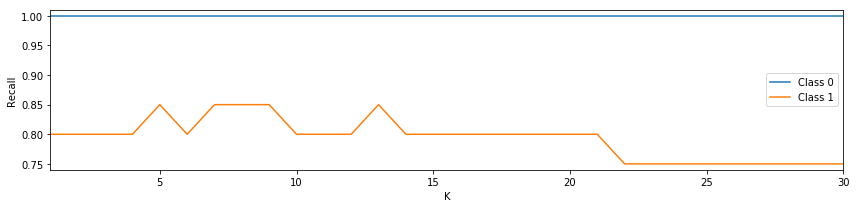

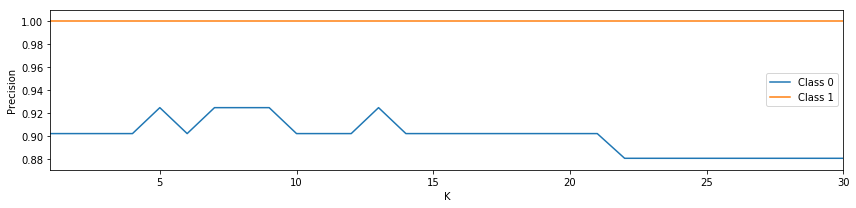

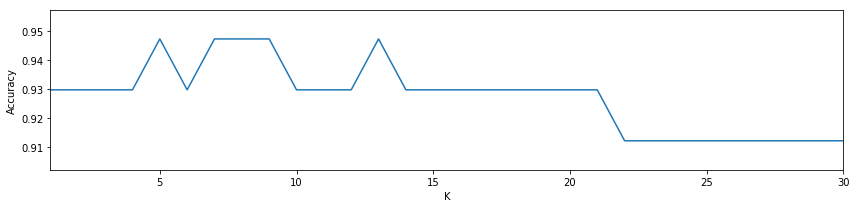

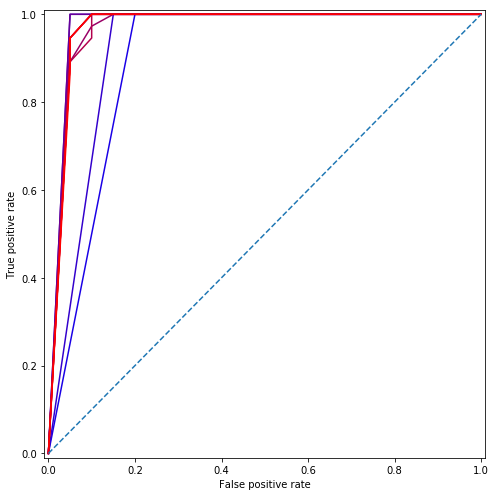

In [95]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

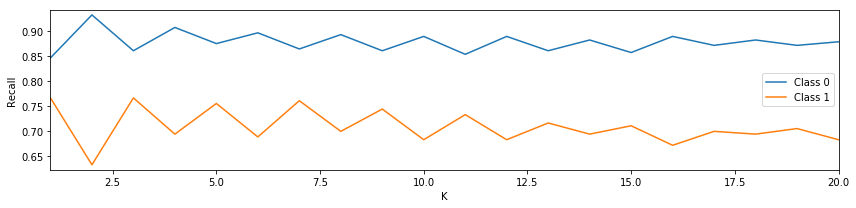

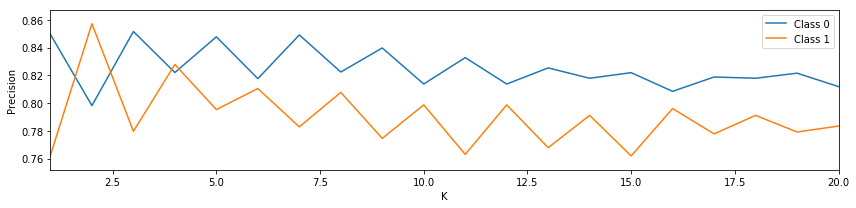

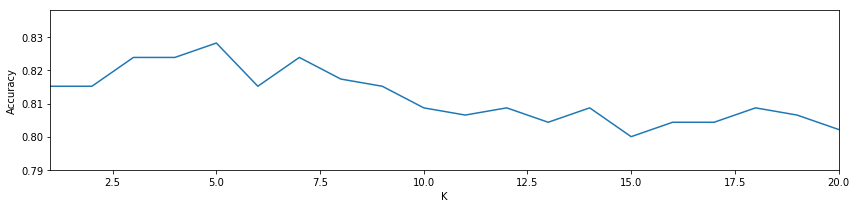

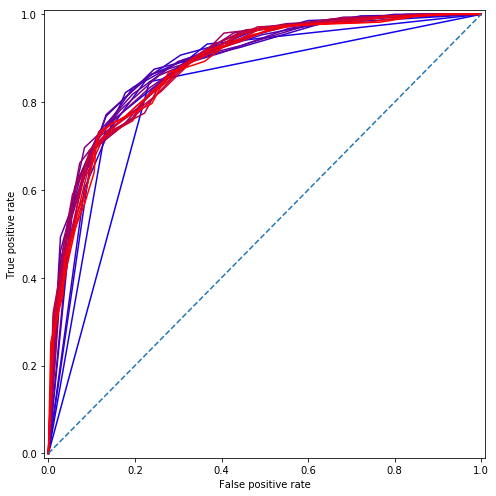

In [96]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

**MinMax scaler**

In [128]:
def MinMaxScaler(X_train, X_test):
    maxs = np.max(X_train, axis=0)
    mins = np.min(X_train, axis=0)
    dens = maxs-mins
    new_train = (X_train[:,] - maxs) / dens
    new_test = (X_test[:,] - maxs) / dens
    return new_train, new_test

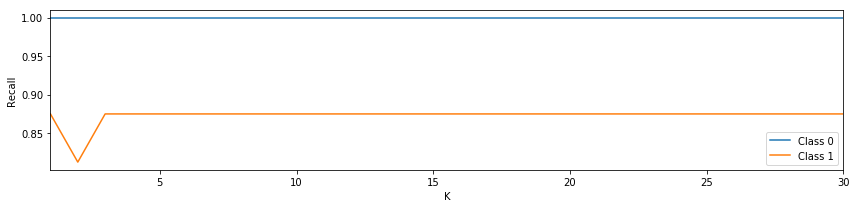

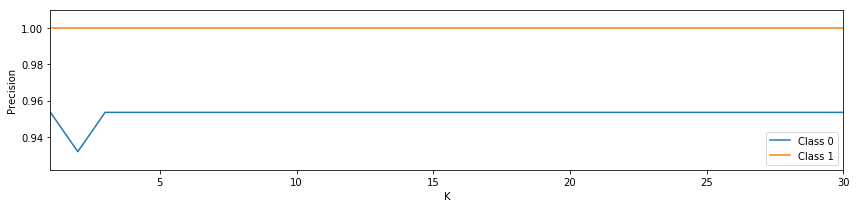

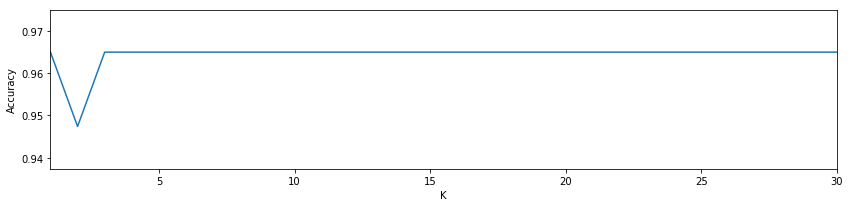

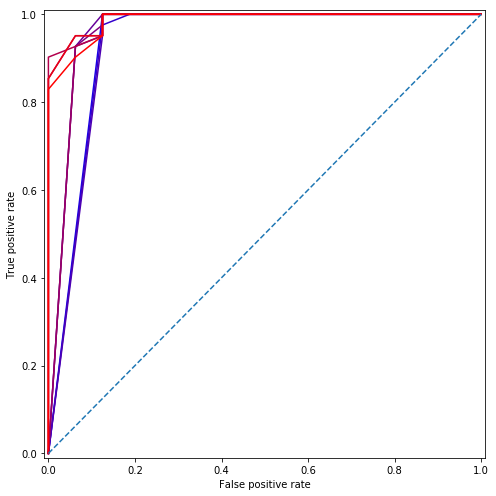

In [129]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = MinMaxScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

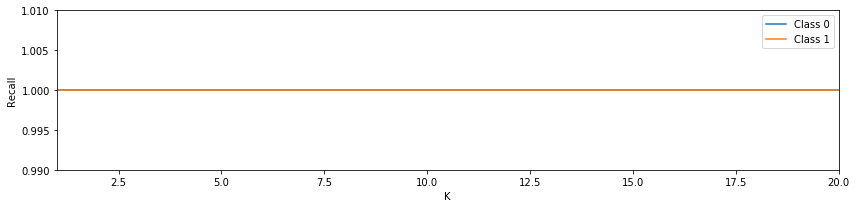

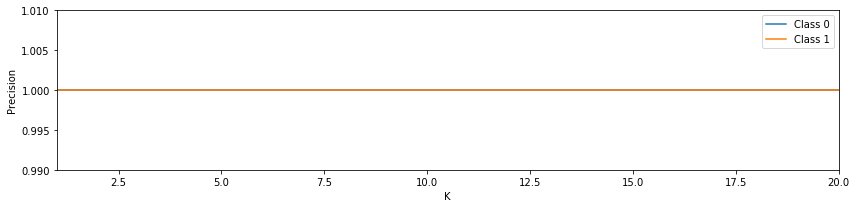

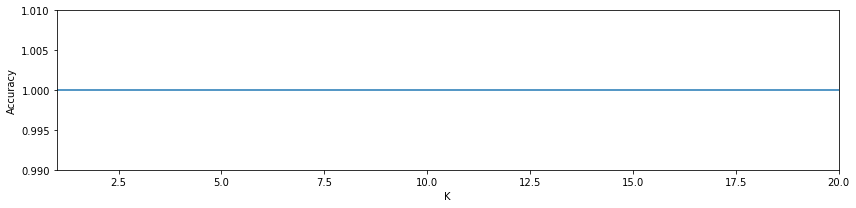

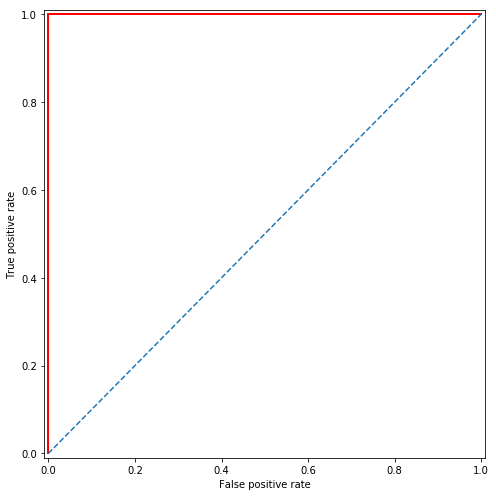

In [138]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = MinMaxScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

**MaxAbs Scaler**

In [141]:
def MaxAbsScaler(X_train, X_test):
    maxs = np.max(abs(X_train), axis=0)
    new_train = X_train[:,] / maxs
    new_test = X_test[:,] / maxs
    return new_train, new_test

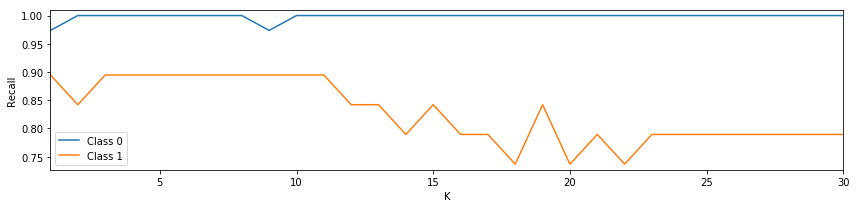

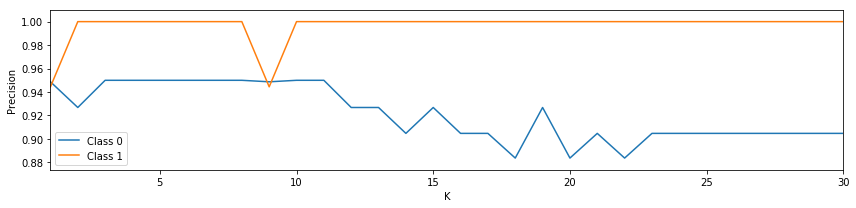

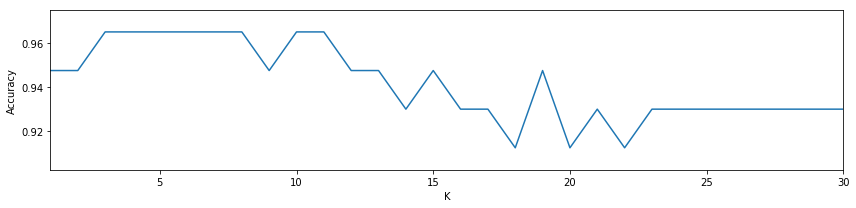

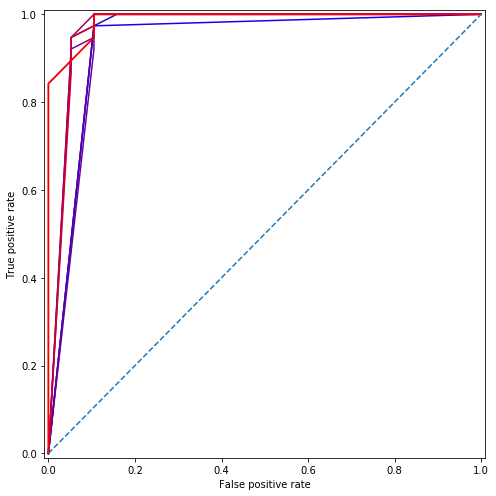

In [142]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = MaxAbsScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

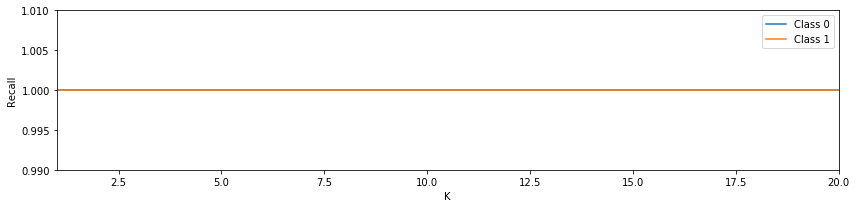

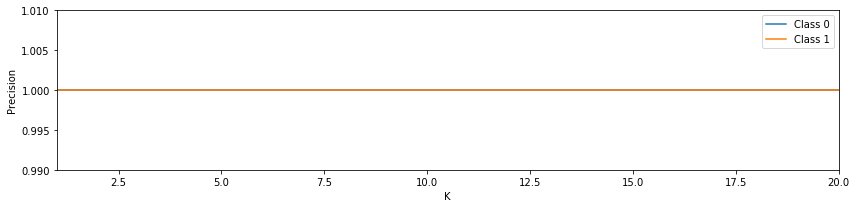

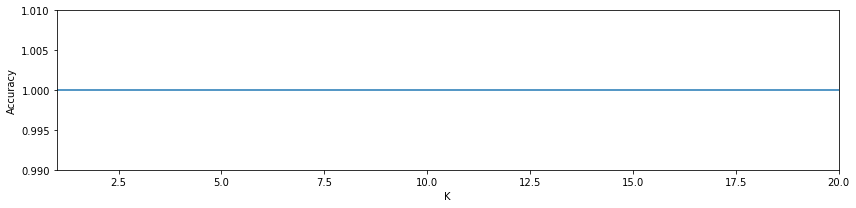

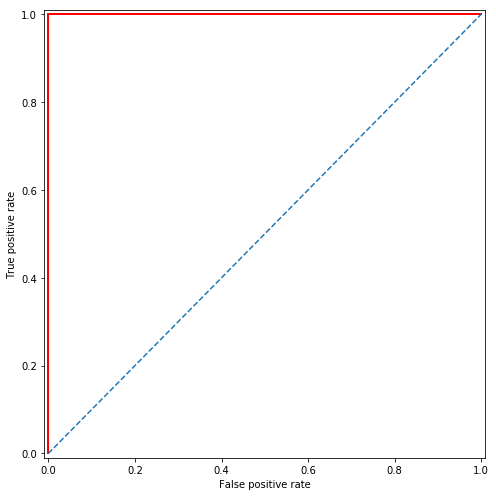

In [146]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = MaxAbsScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

**Std Scaler**

In [133]:
def StdScaler(X_train, X_test):
    means = np.mean(X_train, axis=0)
    stds = np.std(X_train, axis=0)
    stds[stds==0] = 1
    new_train = (X_train[:,] -means) / stds
    new_test = (X_test[:,] -means)/ stds
    return new_train, new_test

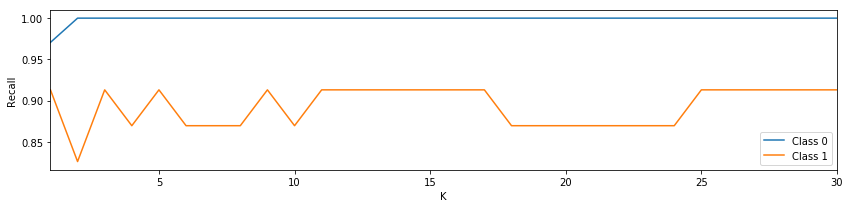

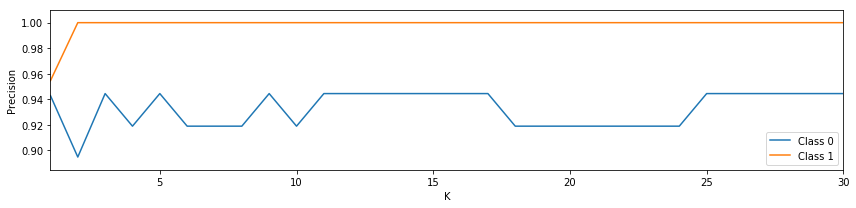

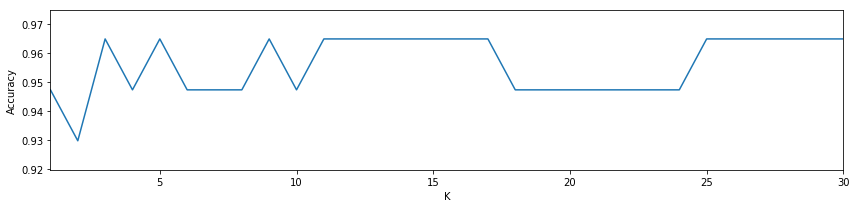

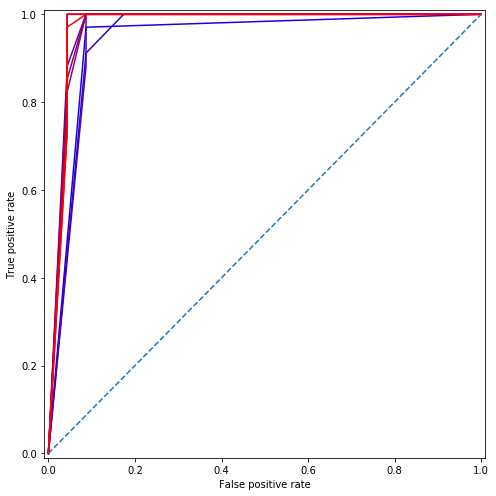

In [135]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = StdScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

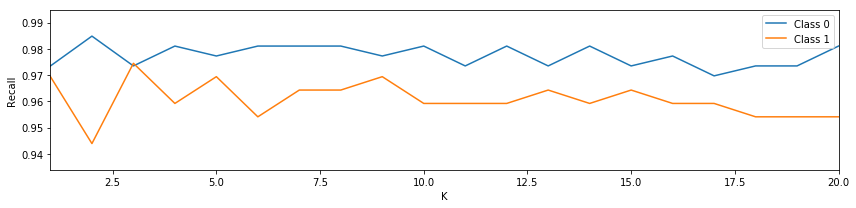

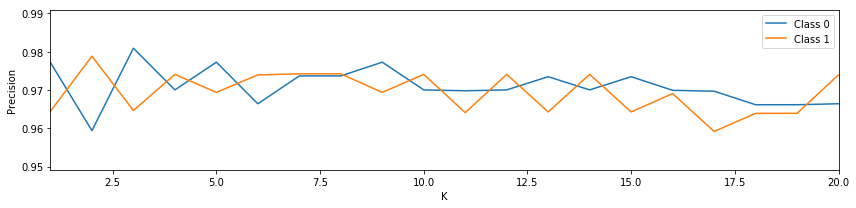

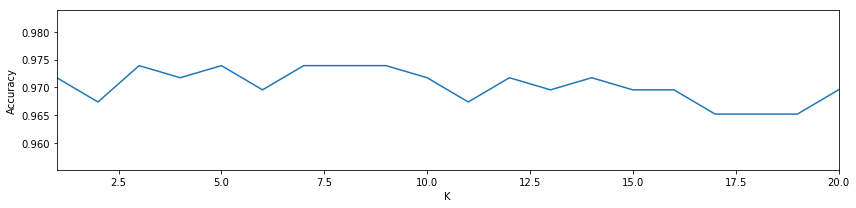

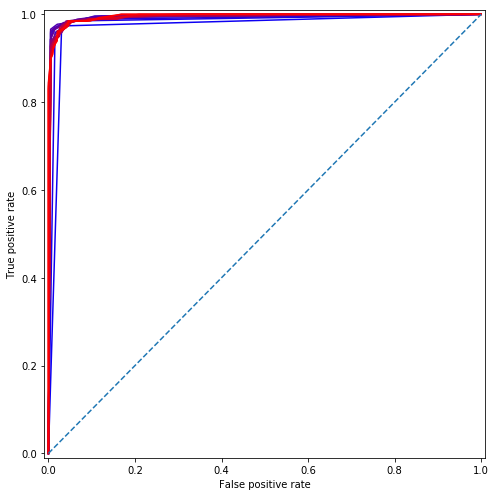

In [144]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = StdScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

**Percentile Scaler**

In [136]:
def PercentileScaler(X_train, X_test, left=25., right=75.):
    meds = np.percentile(X_train, q = 50, axis=0)
    left = np.percentile(X_train, q = left, axis=0)
    right = np.percentile(X_train, q = right, axis=0)
    dens = right - left
    dens[dens==0] = 1
    new_train = (X_train[:,] - meds) / dens
    new_test = (X_test[:,] - meds)/ dens
    return new_train, new_test

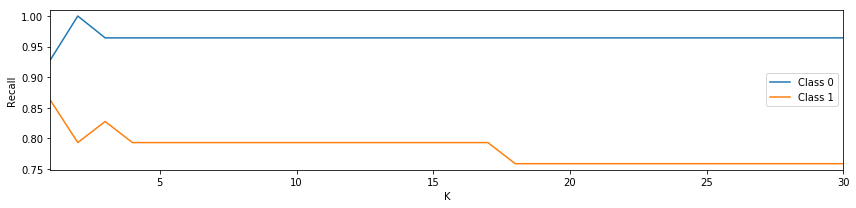

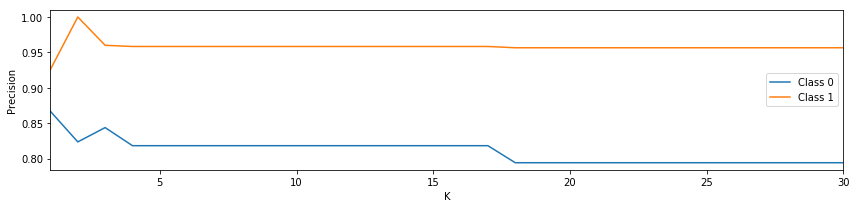

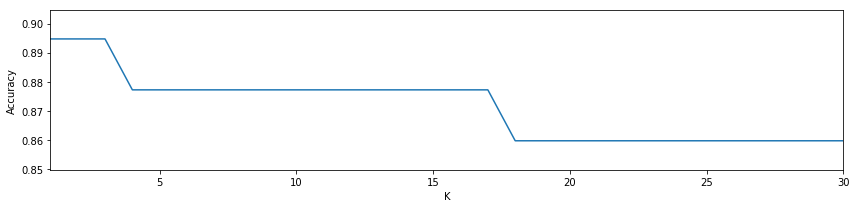

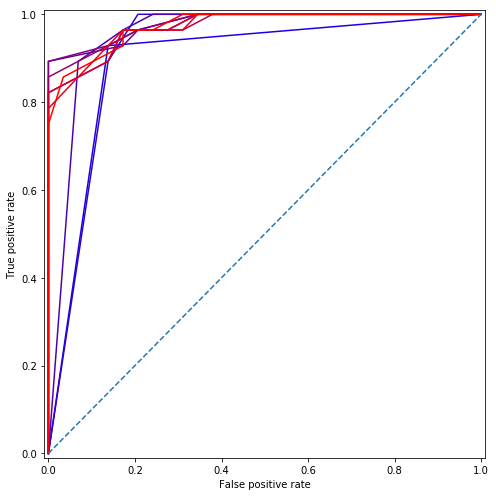

In [137]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = PercentileScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

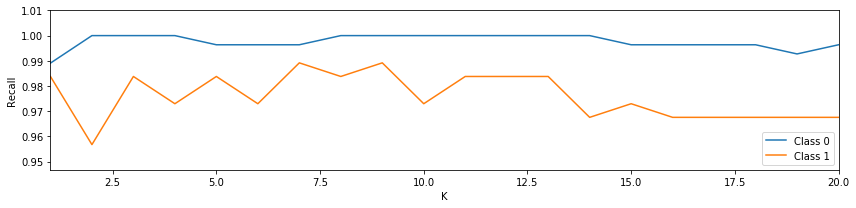

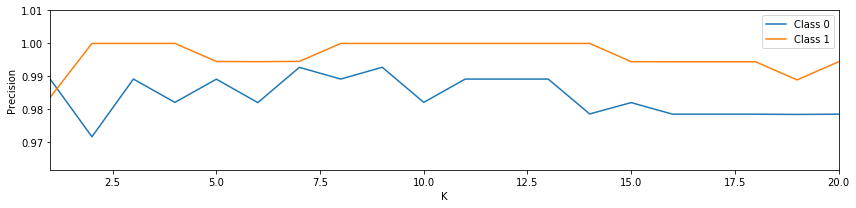

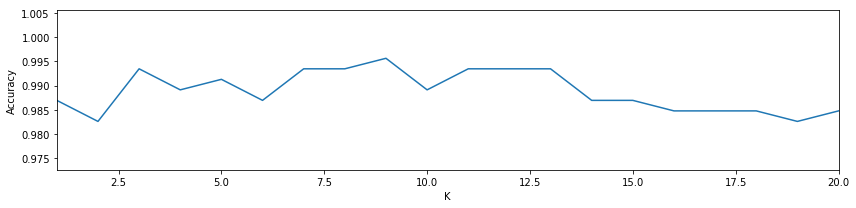

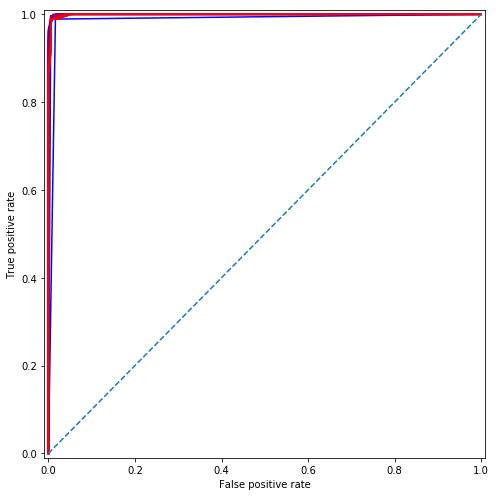

In [145]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train, X_test = StdScaler(X_train, X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)